### Homework 8

In [1]:
import pandas as pd
import numpy as np
import talib
import matplotlib.pyplot as plt
from functools import reduce

import pickle

In [2]:
data_location = 'sqlite:///../../data/data.db'

In [3]:
ohlc = pd.read_sql('SELECT * FROM ohlc', data_location)
ohlc.shape

(11627, 9)

In [4]:
ohlc.head()

,ts,open,high,low,close,volume,volumeUSD,token,chain
0,2021-11-01 00:00:00,61421.37,61669.14,61239.60,61343.68,256.433869,1.575751e+07,BTC,BTC
1,2021-11-01 01:00:00,61346.17,61709.82,61171.22,61610.93,332.481185,2.044558e+07,BTC,BTC
2,2021-11-01 02:00:00,61610.94,61779.87,61299.89,61333.17,314.250720,1.935390e+07,BTC,BTC
3,2021-11-01 03:00:00,61333.17,61457.28,60050.00,60589.06,1059.931358,6.414625e+07,BTC,BTC
4,2021-11-01 04:00:00,60590.23,60655.00,59752.92,59971.89,621.419878,3.744744e+07,BTC,BTC


#### Feature Engineering

In [5]:
tokens = ohlc.token.unique()

In [6]:
def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

def calculate_features(token):
    df = ohlc[ohlc['token']==token].copy()
    df['ret'] = df.close.pct_change()
    df['mfi'] = talib.MFI(df.high, df.low, df.close, df.volume, timeperiod=14) / 100
    df['mom_5'] = talib.MOM(df.close, timeperiod=5) / df.close
    df['mom_10'] = talib.MOM(df.close, timeperiod=10) / df.close
    df['ppo'] = talib.PPO(df.close, fastperiod=12, slowperiod=26, matype=0)
    df['rsi'] = talib.RSI(df.close, timeperiod=14) / 100
    df['obv'] = talib.OBV(df.close, df.volume) / df.volume
    df['obv'] = np.sign(df.obv) * np.log(df.obv.abs())
    df['vol'] = vol_ohlc(df).fillna(0)
    df['atr'] = talib.ATR(df.high, df.low, df.close, timeperiod=14) / df.close
    
    select_columns = ['ts', 'ret', 'mfi', 'mom_5', 'mom_10', 'ppo', 'rsi', 'obv', 'vol', 'atr']
    df = df[select_columns].rename(
        columns={col: f'{col}_{token}' for col in select_columns if col != 'ts'})
    return df
        

def df_merge(left, right):
    return pd.merge(left, right, on='ts', how='inner')
    
X = reduce(df_merge, [calculate_features(token) for token in tokens]).set_index('ts')

In [7]:
X.shape

(1057, 99)

In [8]:
y = X.ret_SOL.shift(-1)[:-1]
X = X[:-1]

In [9]:
y.describe()

count    1056.000000
mean       -0.000156
std         0.012010
min        -0.053429
25%        -0.007444
50%        -0.000503
75%         0.006740
max         0.048298
Name: ret_SOL, dtype: float64

In [10]:
from pandas.plotting import scatter_matrix, autocorrelation_plot

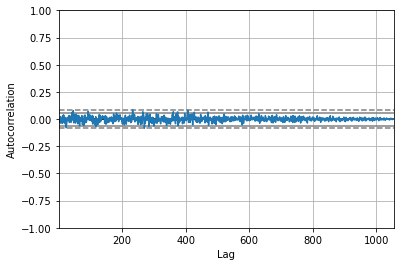

In [11]:
fig = autocorrelation_plot(y[1:])

#### Modeling

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor

from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.model_selection import learning_curve

In [13]:
def evaluate_model(model, X, y, test_size=0.2):
    cv = TimeSeriesSplit(n_splits=int(y.shape[0] * test_size), test_size=1)
    scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)
    
    return np.mean(cross_validate(model, X, y, cv=cv, scoring=scorer, n_jobs=16)['test_score'])

In [14]:
pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=5)),
    ('model', Ridge(alpha=1.0))
])

evaluate_model(pipeline, X, y)

-0.008553573493727566

In [15]:
%%time
pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('model', LGBMRegressor(n_estimators=20, max_depth=5, learning_rate=0.1, colsample_bytree=0.7))
])

evaluate_model(pipeline, X, y)

Wall time: 15.6 s


-0.0085366918385034

#### Grid Search

In [16]:
%%time

from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('model', LGBMRegressor(colsample_bytree=0.7))
])

test_size = 0.2
cv = TimeSeriesSplit(n_splits=int(y.shape[0] * test_size), test_size=1)
scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

search = GridSearchCV(pipeline, {
    'model__n_estimators': [10, 30, 100],
    'model__max_depth': [3, 5, 8],
    'model__learning_rate': [0.01, 0.05, 0.1],
}, scoring=scorer, refit=True, cv=cv, n_jobs=-1)
search.fit(X, y)

Wall time: 7min 24s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=211, test_size=1),
             estimator=Pipeline(steps=[('impute',
                                        SimpleImputer(fill_value=0.0,
                                                      strategy='constant')),
                                       ('model',
                                        LGBMRegressor(colsample_bytree=0.7))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01, 0.05, 0.1],
                         'model__max_depth': [3, 5, 8],
                         'model__n_estimators': [10, 30, 100]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False))

In [17]:
search.best_params_

{'model__learning_rate': 0.05,
 'model__max_depth': 5,
 'model__n_estimators': 30}

In [18]:
best_model = search.best_estimator_

In [19]:
evaluate_model(best_model, X, y)

-0.008499078444061552

#### Plot Learning Curve

In [20]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring=None
):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
        scoring=scoring,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

<module 'matplotlib.pyplot' from 'D:\\software\\anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

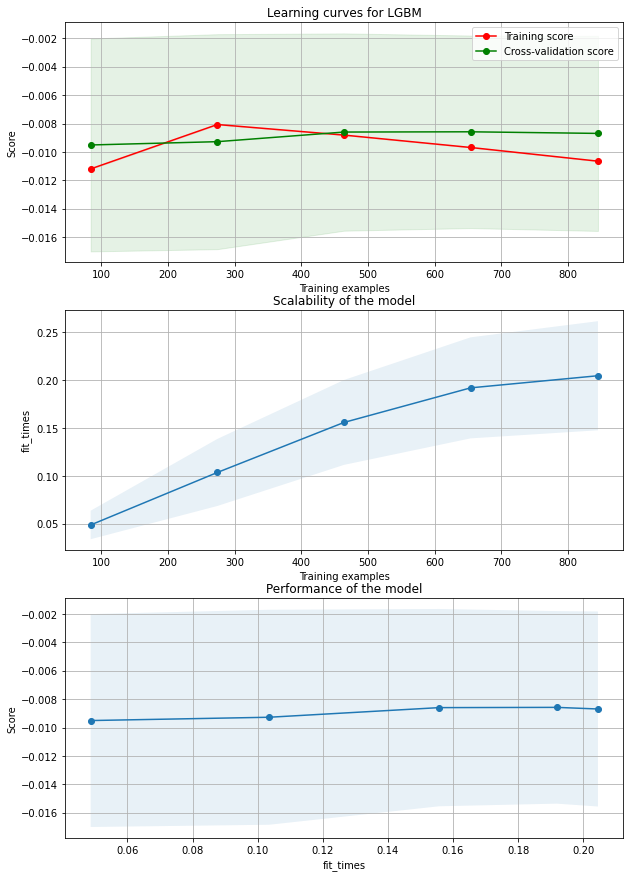

In [21]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

title = "Learning curves for LGBM"

plot_learning_curve(
    best_model, title, X, y, axes=axes, cv=cv, n_jobs=4, scoring=scorer
)


#### Save model

In [22]:
pickle.dump(best_model, open('best_model.pkl', 'wb'))